In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import d3rlpy
import torch
import numpy as np
from matplotlib import pyplot as plt
from makeSeaquestdata import load_seaquest_dataset, make_seaquest_testset
from load_model import load_seaquest_model
from model import make_episodes, fit_discrete_sac, fit_per_cluster
from utils import create_trajectories, get_trajectory_embedding, perform_clustering_and_plot, trajectory_attributions_sq, set_seeds, print_results_sq
from encoder import CustomCNNFactory

c:\Users\jortv\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# Set device and random seed
device = set_seeds(seed=0)

# Set data and test sizes
data_size, test_size = 250, 100

In [14]:
# Load Seaquest dataset
seaquestdata, sq_env = load_seaquest_dataset(env_name='Breakout', size=data_size+test_size)

print(seaquestdata["observations"][0])
print(seaquestdata["actions"][:10])
print(seaquestdata["rewards"][:10])
print(seaquestdata["terminals"][:10])

decompressing data...
Dataset loaded
789
Dataset extracted with 444324 samples.
Information about the dataset:
Observation shape:  (444324, 4, 84, 84)
Action shape:  (444324,)
Reward shape:  (444324,)
Terminal shape:  (444324,)
Action space:  4
Observation space:  (84, 84)
Number of terminal states is... 349
Environment 'ALE/Breakout-ram-v5' initialized.
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[1 0 1 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0 0 0 0 0 0 0 0 0 0]


In [15]:
# Load pre-trained encoders
pre_trained_encoder_seaquest = load_seaquest_model("decision_transformer_atari/checkpoints/Breakout_123.pth", seed=0)

# Create Seaquest test set
seaquestdata, test_observation_sq = make_seaquest_testset(seaquestdata, data_size, test_size)

In [16]:
# Create trajectories and obtain embeddings for Seaquest data
final_obs_sq, final_act_sq, final_rew_sq, _ = create_trajectories(
    seaquestdata["observations"], seaquestdata["actions"], 
    seaquestdata["rewards"], seaquestdata["terminals"], trajectory_length=15
)
trajectory_embedding_seaquest = get_trajectory_embedding(
    pre_trained_encoder_seaquest, final_obs_sq, final_act_sq, final_rew_sq, 
    is_seaquest=True, device=device
)

Processing sub'trajectories: 100%|██████████| 317114/317114 [00:18<00:00, 16905.85it/s]
c:\Users\jortv\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\cuda\amp\grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Processing trajectories:   0%|          | 0/21270 [00:00<?, ?it/s]c:\Users\jortv\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Processing trajectories: 100%|██████████| 21270/21270 [04:34<00:00, 77.47it/s]


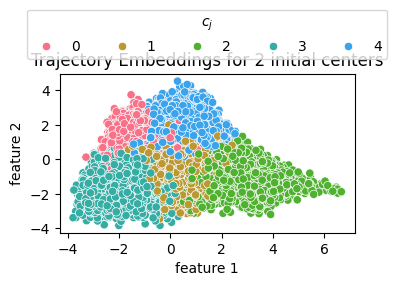

In [17]:
# Perform clustering on Seaquest data
clusters_seaquest, _ = perform_clustering_and_plot(trajectory_embedding_seaquest.detach().cpu().numpy(), 2, 5, ccore=True, plot=True)

In [18]:
 # Train Seaquest model with DiscreteSAC
print('#' * 100)
print("Training Seaquest with DiscreteSAC...")
list_episodes_sq = make_episodes(final_obs_sq, final_act_sq, final_rew_sq, 4)
print(list_episodes_sq[0])
sac_sq = fit_discrete_sac(list_episodes_sq, n_steps=10, n_steps_per_epoch=1, device=device)

####################################################################################################
Training Seaquest with DiscreteSAC...
2024-04-21 15:55:45 [debug    ] RandomIterator is selected.   
2024-04-21 15:55:45 [info     ] Directory is created at d3rlpy_logs\DiscreteSAC_20240421155545
2024-04-21 15:55:45 [debug    ] Fitting scaler...              scaler=pixel
2024-04-21 15:55:45 [debug    ] Building models...            
2024-04-21 15:55:45 [debug    ] Models have been built.       
2024-04-21 15:55:45 [info     ] Parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155545\params.json params={'action_scaler': None, 'actor_encoder_factory': {'type': 'custom', 'params': {'feature_size': 128}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 0.0001, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'custom', 'params': {'feature_size': 128}}, 'critic_learning_rate': 0.0003, 'cr

Epoch 1/10: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s, temp_loss=0.0264, temp=1, critic_loss=1.64, actor_loss=-1.37]


2024-04-21 15:55:45 [info     ] DiscreteSAC_20240421155545: epoch=1 step=1 epoch=1 metrics={'time_sample_batch': 0.006003379821777344, 'time_algorithm_update': 0.46779370307922363, 'temp_loss': 0.026416731998324394, 'temp': 0.999701201915741, 'critic_loss': 1.644213080406189, 'actor_loss': -1.3656871318817139, 'time_step': 0.4757966995239258} step=1
2024-04-21 15:55:45 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155545\model_1.pt


Epoch 2/10: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s, temp_loss=0.0266, temp=0.999, critic_loss=1.62, actor_loss=-1.38]


2024-04-21 15:55:46 [info     ] DiscreteSAC_20240421155545: epoch=2 step=2 epoch=2 metrics={'time_sample_batch': 0.017045021057128906, 'time_algorithm_update': 0.27080869674682617, 'temp_loss': 0.02664683572947979, 'temp': 0.9994023442268372, 'critic_loss': 1.6203720569610596, 'actor_loss': -1.3807921409606934, 'time_step': 0.2899436950683594} step=2
2024-04-21 15:55:46 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155545\model_2.pt


Epoch 3/10: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s, temp_loss=0.0267, temp=0.999, critic_loss=1.64, actor_loss=-1.4]


2024-04-21 15:55:46 [info     ] DiscreteSAC_20240421155545: epoch=3 step=3 epoch=3 metrics={'time_sample_batch': 0.00651097297668457, 'time_algorithm_update': 0.26010584831237793, 'temp_loss': 0.02674294263124466, 'temp': 0.9991036057472229, 'critic_loss': 1.6430740356445312, 'actor_loss': -1.3972944021224976, 'time_step': 0.26864004135131836} step=3
2024-04-21 15:55:46 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155545\model_3.pt


Epoch 4/10: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s, temp_loss=0.0268, temp=0.999, critic_loss=1.57, actor_loss=-1.42]


2024-04-21 15:55:46 [info     ] DiscreteSAC_20240421155545: epoch=4 step=4 epoch=4 metrics={'time_sample_batch': 0.008629322052001953, 'time_algorithm_update': 0.2523198127746582, 'temp_loss': 0.026767466217279434, 'temp': 0.9988048672676086, 'critic_loss': 1.568942666053772, 'actor_loss': -1.4197916984558105, 'time_step': 0.2619588375091553} step=4
2024-04-21 15:55:46 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155545\model_4.pt


Epoch 5/10: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s, temp_loss=0.0267, temp=0.999, critic_loss=1.55, actor_loss=-1.45]


2024-04-21 15:55:47 [info     ] DiscreteSAC_20240421155545: epoch=5 step=5 epoch=5 metrics={'time_sample_batch': 0.01053166389465332, 'time_algorithm_update': 0.2810225486755371, 'temp_loss': 0.02673889696598053, 'temp': 0.9985062479972839, 'critic_loss': 1.551795482635498, 'actor_loss': -1.4510282278060913, 'time_step': 0.292621374130249} step=5
2024-04-21 15:55:47 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155545\model_5.pt


Epoch 6/10: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s, temp_loss=0.0266, temp=0.998, critic_loss=1.48, actor_loss=-1.49]


2024-04-21 15:55:47 [info     ] DiscreteSAC_20240421155545: epoch=6 step=6 epoch=6 metrics={'time_sample_batch': 0.009697198867797852, 'time_algorithm_update': 0.2685866355895996, 'temp_loss': 0.026646360754966736, 'temp': 0.998207688331604, 'critic_loss': 1.482765555381775, 'actor_loss': -1.4947854280471802, 'time_step': 0.2792825698852539} step=6
2024-04-21 15:55:47 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155545\model_6.pt


Epoch 7/10: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s, temp_loss=0.0265, temp=0.998, critic_loss=1.35, actor_loss=-1.55]


2024-04-21 15:55:47 [info     ] DiscreteSAC_20240421155545: epoch=7 step=7 epoch=7 metrics={'time_sample_batch': 0.008533954620361328, 'time_algorithm_update': 0.2617063522338867, 'temp_loss': 0.026475723832845688, 'temp': 0.997909426689148, 'critic_loss': 1.3483600616455078, 'actor_loss': -1.5545660257339478, 'time_step': 0.27024030685424805} step=7
2024-04-21 15:55:47 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155545\model_7.pt


Epoch 8/10: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s, temp_loss=0.0262, temp=0.998, critic_loss=1.26, actor_loss=-1.64]


2024-04-21 15:55:48 [info     ] DiscreteSAC_20240421155545: epoch=8 step=8 epoch=8 metrics={'time_sample_batch': 0.007332563400268555, 'time_algorithm_update': 0.2621140480041504, 'temp_loss': 0.026212844997644424, 'temp': 0.9976114630699158, 'critic_loss': 1.2556979656219482, 'actor_loss': -1.6367509365081787, 'time_step': 0.27050304412841797} step=8
2024-04-21 15:55:48 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155545\model_8.pt


Epoch 9/10: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s, temp_loss=0.0258, temp=0.997, critic_loss=1.09, actor_loss=-1.75]


2024-04-21 15:55:48 [info     ] DiscreteSAC_20240421155545: epoch=9 step=9 epoch=9 metrics={'time_sample_batch': 0.0056645870208740234, 'time_algorithm_update': 0.2703359127044678, 'temp_loss': 0.025832146406173706, 'temp': 0.9973139762878418, 'critic_loss': 1.0872472524642944, 'actor_loss': -1.7511577606201172, 'time_step': 0.27701401710510254} step=9
2024-04-21 15:55:48 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155545\model_9.pt


Epoch 10/10: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s, temp_loss=0.0253, temp=0.997, critic_loss=0.84, actor_loss=-1.9]


2024-04-21 15:55:48 [info     ] DiscreteSAC_20240421155545: epoch=10 step=10 epoch=10 metrics={'time_sample_batch': 0.0075550079345703125, 'time_algorithm_update': 0.28707432746887207, 'temp_loss': 0.025343524292111397, 'temp': 0.9970172643661499, 'critic_loss': 0.8395079374313354, 'actor_loss': -1.9016964435577393, 'time_step': 0.29565978050231934} step=10
2024-04-21 15:55:48 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155545\model_10.pt


In [19]:
# Compute all possible permutations of clusters
feature_size = 128
custom_encoder_actor = CustomCNNFactory(feature_size)
custom_encoder_critic = CustomCNNFactory(feature_size)

model_params_sq = {
    'actor_learning_rate': 3e-4,
    'critic_learning_rate': 3e-4,
    'temp_learning_rate': 3e-4,
    'batch_size': 256,
    'actor_encoder_factory': custom_encoder_actor,
    'critic_encoder_factory': custom_encoder_critic,
    'scaler': 'pixel',
    'use_gpu': True if device == 'cuda' else False
}

In [20]:
# Fit models per cluster for Seaquest data
models_sq, result_data_combinations_sq = fit_per_cluster(
    model=sac_sq, 
    model_class=d3rlpy.algos.DiscreteSAC,
    model_params=model_params_sq,
    data_embedding=trajectory_embedding_seaquest,
    list_episodes=list_episodes_sq,
    clusters=clusters_seaquest,
    trajectory_embedding=trajectory_embedding_seaquest,
    test_observations=test_observation_sq
)

Original model action:  [0]
Original model action value:  [0.61867225]
Passing:  0 0.61867225
Original model action:  [0]
Original model action value:  [0.61881286]
Passing:  0 0.61881286
Original model action:  [0]
Original model action value:  [0.6176788]
Passing:  0 0.6176788
Original model action:  [0]
Original model action value:  [0.6162407]
Passing:  0 0.6162407
Original model action:  [0]
Original model action value:  [0.61638516]
Passing:  0 0.61638516
Original model action:  [0]
Original model action value:  [0.62290967]
Passing:  0 0.62290967
Original model action:  [0]
Original model action value:  [0.61240494]
Passing:  0 0.61240494
Original model action:  [0]
Original model action value:  [0.62256986]
Passing:  0 0.62256986
Original model action:  [0]
Original model action value:  [0.61867225]
Passing:  0 0.61867225
Original model action:  [0]
Original model action value:  [0.6127013]
Passing:  0 0.6127013
Original model action:  [0]
Original model action value:  [0.61657

Epoch 1/10: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s, temp_loss=0.0269, temp=1, critic_loss=1.64, actor_loss=-1.35]


2024-04-21 15:55:53 [info     ] DiscreteSAC_20240421155550: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.0065442085266113285, 'time_algorithm_update': 0.2553325414657593, 'temp_loss': 0.026795721240341665, 'temp': 0.998357605934143, 'critic_loss': 1.2287010490894317, 'actor_loss': -1.6305169463157654, 'time_step': 0.2621286153793335} step=10
2024-04-21 15:55:53 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155550\model_10.pt


Epoch 2/10: 100%|██████████| 10/10 [00:02<00:00,  3.96it/s, temp_loss=0.0223, temp=0.997, critic_loss=0.32, actor_loss=-2.52]


2024-04-21 15:55:56 [info     ] DiscreteSAC_20240421155550: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.0070369958877563475, 'time_algorithm_update': 0.2444756507873535, 'temp_loss': 0.0014912026003003121, 'temp': 0.9958028137683869, 'critic_loss': 0.28989154398441314, 'actor_loss': -2.6794260025024412, 'time_step': 0.2516125917434692} step=20
2024-04-21 15:55:56 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155550\model_20.pt


Epoch 3/10: 100%|██████████| 10/10 [00:02<00:00,  3.97it/s, temp_loss=0.019, temp=0.995, critic_loss=0.237, actor_loss=-2.26]


2024-04-21 15:55:58 [info     ] DiscreteSAC_20240421155550: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.00630185604095459, 'time_algorithm_update': 0.24449315071105956, 'temp_loss': 0.025410350784659384, 'temp': 0.9942424833774567, 'critic_loss': 0.23076391518115996, 'actor_loss': -2.457541656494141, 'time_step': 0.2510474443435669} step=30
2024-04-21 15:55:58 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155550\model_30.pt


Epoch 4/10: 100%|██████████| 10/10 [00:02<00:00,  4.09it/s, temp_loss=0.0272, temp=0.993, critic_loss=0.22, actor_loss=-2.85]


2024-04-21 15:56:01 [info     ] DiscreteSAC_20240421155550: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.00663750171661377, 'time_algorithm_update': 0.2365572214126587, 'temp_loss': 0.026974960416555404, 'temp': 0.9916538417339325, 'critic_loss': 0.1812112145125866, 'actor_loss': -2.670223569869995, 'time_step': 0.24335334300994874} step=40
2024-04-21 15:56:01 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155550\model_40.pt


Epoch 5/10: 100%|██████████| 10/10 [00:02<00:00,  4.17it/s, temp_loss=0.0267, temp=0.99, critic_loss=0.153, actor_loss=-2.48]


2024-04-21 15:56:03 [info     ] DiscreteSAC_20240421155550: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.00637965202331543, 'time_algorithm_update': 0.2320091724395752, 'temp_loss': 0.026580540277063847, 'temp': 0.9886258602142334, 'critic_loss': 0.15703131705522538, 'actor_loss': -2.5921688795089723, 'time_step': 0.23858976364135742} step=50
2024-04-21 15:56:03 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155550\model_50.pt


Epoch 6/10: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s, temp_loss=0.0266, temp=0.987, critic_loss=0.105, actor_loss=-2.69]


2024-04-21 15:56:06 [info     ] DiscreteSAC_20240421155550: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.005864930152893066, 'time_algorithm_update': 0.23916783332824706, 'temp_loss': 0.026639887318015098, 'temp': 0.9855154871940612, 'critic_loss': 0.1447366587817669, 'actor_loss': -2.6056077241897584, 'time_step': 0.24513373374938965} step=60
2024-04-21 15:56:06 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155550\model_60.pt


Epoch 7/10: 100%|██████████| 10/10 [00:02<00:00,  4.10it/s, temp_loss=0.0267, temp=0.984, critic_loss=0.154, actor_loss=-2.57]


2024-04-21 15:56:08 [info     ] DiscreteSAC_20240421155550: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.006252741813659668, 'time_algorithm_update': 0.23617920875549317, 'temp_loss': 0.026817035488784315, 'temp': 0.9824010550975799, 'critic_loss': 0.13878129422664642, 'actor_loss': -2.6152002573013307, 'time_step': 0.2425319194793701} step=70
2024-04-21 15:56:08 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155550\model_70.pt


Epoch 8/10: 100%|██████████| 10/10 [00:02<00:00,  4.14it/s, temp_loss=0.0269, temp=0.981, critic_loss=0.13, actor_loss=-2.6]


2024-04-21 15:56:10 [info     ] DiscreteSAC_20240421155550: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.006631374359130859, 'time_algorithm_update': 0.2338808536529541, 'temp_loss': 0.026908250525593758, 'temp': 0.97929927110672, 'critic_loss': 0.12964585795998573, 'actor_loss': -2.6072518825531006, 'time_step': 0.24071426391601564} step=80
2024-04-21 15:56:11 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155550\model_80.pt


Epoch 9/10: 100%|██████████| 10/10 [00:02<00:00,  4.10it/s, temp_loss=0.0269, temp=0.978, critic_loss=0.144, actor_loss=-2.6]


2024-04-21 15:56:13 [info     ] DiscreteSAC_20240421155550: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.006160211563110351, 'time_algorithm_update': 0.23642022609710694, 'temp_loss': 0.026940197683870792, 'temp': 0.976217406988144, 'critic_loss': 0.1495085522532463, 'actor_loss': -2.5768853425979614, 'time_step': 0.2426833391189575} step=90
2024-04-21 15:56:13 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155550\model_90.pt


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, temp_loss=0.0269, temp=0.975, critic_loss=0.141, actor_loss=-2.57]


2024-04-21 15:56:16 [info     ] DiscreteSAC_20240421155550: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.007063770294189453, 'time_algorithm_update': 0.24831089973449708, 'temp_loss': 0.026919741369783878, 'temp': 0.9731586217880249, 'critic_loss': 0.1374522976577282, 'actor_loss': -2.6029194831848144, 'time_step': 0.2554755449295044} step=100
2024-04-21 15:56:16 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155550\model_100.pt
New model action:  [0]
New model action value:  [1.1766952]
Passing:  0 1.1766952
New model action:  [0]
New model action value:  [1.1772194]
Passing:  0 1.1772194
New model action:  [0]
New model action value:  [1.1769876]
Passing:  0 1.1769876
New model action:  [0]
New model action value:  [1.1736118]
Passing:  0 1.1736118
New model action:  [0]
New model action value:  [1.1742415]
Passing:  0 1.1742415
New model action:  [0]
New model action value:  [1.1814748]
Passing:  0 1.1814748
New model action:  [0]
New model a

Epoch 1/10: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s, temp_loss=0.0273, temp=1, critic_loss=1.67, actor_loss=-1.36]


2024-04-21 15:56:20 [info     ] DiscreteSAC_20240421155618: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.007104754447937012, 'time_algorithm_update': 0.26145904064178466, 'temp_loss': 0.026823814772069455, 'temp': 0.9983589828014374, 'critic_loss': 1.4334702491760254, 'actor_loss': -1.4745256304740906, 'time_step': 0.26880056858062745} step=10
2024-04-21 15:56:20 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155618\model_10.pt


Epoch 2/10: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s, temp_loss=0.0258, temp=0.997, critic_loss=0.838, actor_loss=-1.82]


2024-04-21 15:56:23 [info     ] DiscreteSAC_20240421155618: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.006791877746582031, 'time_algorithm_update': 0.26082558631896974, 'temp_loss': 0.022296343371272086, 'temp': 0.995412939786911, 'critic_loss': 0.40280520617961885, 'actor_loss': -2.525336217880249, 'time_step': 0.26787307262420657} step=20
2024-04-21 15:56:23 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155618\model_20.pt


Epoch 3/10: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s, temp_loss=0.0171, temp=0.994, critic_loss=0.185, actor_loss=-2.41]


2024-04-21 15:56:26 [info     ] DiscreteSAC_20240421155618: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.008369803428649902, 'time_algorithm_update': 0.26959052085876467, 'temp_loss': 0.022064789570868014, 'temp': 0.9926590085029602, 'critic_loss': 0.23488338887691498, 'actor_loss': -2.367575240135193, 'time_step': 0.27806046009063723} step=30
2024-04-21 15:56:26 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155618\model_30.pt


Epoch 4/10: 100%|██████████| 10/10 [00:02<00:00,  3.64it/s, temp_loss=0.0262, temp=0.991, critic_loss=0.186, actor_loss=-2.65]


2024-04-21 15:56:29 [info     ] DiscreteSAC_20240421155618: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.007608819007873535, 'time_algorithm_update': 0.26546335220336914, 'temp_loss': 0.026752503030002116, 'temp': 0.9898074388504028, 'critic_loss': 0.17111968323588372, 'actor_loss': -2.7087680101394653, 'time_step': 0.2733815908432007} step=40
2024-04-21 15:56:29 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155618\model_40.pt


Epoch 5/10: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s, temp_loss=0.027, temp=0.988, critic_loss=0.112, actor_loss=-2.54]


2024-04-21 15:56:31 [info     ] DiscreteSAC_20240421155618: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.0072433710098266605, 'time_algorithm_update': 0.2543586015701294, 'temp_loss': 0.026982965320348738, 'temp': 0.9867619216442108, 'critic_loss': 0.1545329786837101, 'actor_loss': -2.569165277481079, 'time_step': 0.26180324554443357} step=50
2024-04-21 15:56:31 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155618\model_50.pt


Epoch 6/10: 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, temp_loss=0.0269, temp=0.985, critic_loss=0.137, actor_loss=-2.69]


2024-04-21 15:56:34 [info     ] DiscreteSAC_20240421155618: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.007127881050109863, 'time_algorithm_update': 0.24830212593078613, 'temp_loss': 0.026865360885858537, 'temp': 0.9836709856986999, 'critic_loss': 0.15362492948770523, 'actor_loss': -2.6262237548828127, 'time_step': 0.25565621852874754} step=60
2024-04-21 15:56:34 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155618\model_60.pt


Epoch 7/10: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s, temp_loss=0.0268, temp=0.982, critic_loss=0.153, actor_loss=-2.57]


2024-04-21 15:56:37 [info     ] DiscreteSAC_20240421155618: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.007113242149353027, 'time_algorithm_update': 0.26139225959777834, 'temp_loss': 0.026812170632183552, 'temp': 0.9805946350097656, 'critic_loss': 0.13956639617681504, 'actor_loss': -2.6100714445114135, 'time_step': 0.2686316013336182} step=70
2024-04-21 15:56:37 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155618\model_70.pt


Epoch 8/10: 100%|██████████| 10/10 [00:02<00:00,  3.88it/s, temp_loss=0.0268, temp=0.979, critic_loss=0.136, actor_loss=-2.61]


2024-04-21 15:56:39 [info     ] DiscreteSAC_20240421155618: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.006629157066345215, 'time_algorithm_update': 0.24987225532531737, 'temp_loss': 0.026853277720510958, 'temp': 0.9775436997413636, 'critic_loss': 0.1375232942402363, 'actor_loss': -2.62162389755249, 'time_step': 0.25660245418548583} step=80
2024-04-21 15:56:39 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155618\model_80.pt


Epoch 9/10: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s, temp_loss=0.0269, temp=0.976, critic_loss=0.13, actor_loss=-2.62]


2024-04-21 15:56:42 [info     ] DiscreteSAC_20240421155618: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.006998634338378907, 'time_algorithm_update': 0.25319907665252683, 'temp_loss': 0.026859029196202755, 'temp': 0.974514776468277, 'critic_loss': 0.14204148799180985, 'actor_loss': -2.6112587690353393, 'time_step': 0.2602987289428711} step=90
2024-04-21 15:56:42 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155618\model_90.pt


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s, temp_loss=0.0268, temp=0.973, critic_loss=0.101, actor_loss=-2.63]


2024-04-21 15:56:45 [info     ] DiscreteSAC_20240421155618: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.007074975967407226, 'time_algorithm_update': 0.254856538772583, 'temp_loss': 0.026764636673033238, 'temp': 0.9715086638927459, 'critic_loss': 0.1318909741938114, 'actor_loss': -2.602319097518921, 'time_step': 0.2620337724685669} step=100
2024-04-21 15:56:45 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155618\model_100.pt
New model action:  [0]
New model action value:  [1.1356685]
Passing:  0 1.1356685
New model action:  [0]
New model action value:  [1.1368039]
Passing:  0 1.1368039
New model action:  [0]
New model action value:  [1.1365242]
Passing:  0 1.1365242
New model action:  [0]
New model action value:  [1.1339031]
Passing:  0 1.1339031
New model action:  [0]
New model action value:  [1.1340034]
Passing:  0 1.1340034
New model action:  [0]
New model action value:  [1.1430905]
Passing:  0 1.1430905
New model action:  [0]
New model acti

Epoch 1/10: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s, temp_loss=0.0263, temp=1, critic_loss=1.68, actor_loss=-1.35]


2024-04-21 15:56:49 [info     ] DiscreteSAC_20240421155647: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.006755924224853516, 'time_algorithm_update': 0.26294360160827634, 'temp_loss': 0.02710841838270426, 'temp': 0.9983556270599365, 'critic_loss': 1.400905680656433, 'actor_loss': -1.5043665528297425, 'time_step': 0.26979951858520507} step=10
2024-04-21 15:56:49 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155647\model_10.pt


Epoch 2/10: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s, temp_loss=0.0256, temp=0.997, critic_loss=0.661, actor_loss=-1.99]


2024-04-21 15:56:52 [info     ] DiscreteSAC_20240421155647: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.00784456729888916, 'time_algorithm_update': 0.28476336002349856, 'temp_loss': -0.0038039472536183895, 'temp': 0.9957066953182221, 'critic_loss': 0.3380321845412254, 'actor_loss': -2.5568559169769287, 'time_step': 0.29302382469177246} step=20
2024-04-21 15:56:52 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155647\model_20.pt


Epoch 3/10: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s, temp_loss=0.00376, temp=0.995, critic_loss=0.175, actor_loss=-2.29]


2024-04-21 15:56:55 [info     ] DiscreteSAC_20240421155647: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.008147478103637695, 'time_algorithm_update': 0.27229421138763427, 'temp_loss': 0.020439523505046964, 'temp': 0.9948254764080048, 'critic_loss': 0.2111976146697998, 'actor_loss': -2.4141287088394163, 'time_step': 0.28064446449279784} step=30
2024-04-21 15:56:55 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155647\model_30.pt


Epoch 4/10: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s, temp_loss=0.0261, temp=0.994, critic_loss=0.172, actor_loss=-2.76]


2024-04-21 15:56:58 [info     ] DiscreteSAC_20240421155647: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.00807194709777832, 'time_algorithm_update': 0.2874244451522827, 'temp_loss': 0.02602628618478775, 'temp': 0.9929262876510621, 'critic_loss': 0.16924737617373467, 'actor_loss': -2.690134882926941, 'time_step': 0.29575061798095703} step=40
2024-04-21 15:56:58 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155647\model_40.pt


Epoch 5/10: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s, temp_loss=0.026, temp=0.992, critic_loss=0.197, actor_loss=-2.49]


2024-04-21 15:57:02 [info     ] DiscreteSAC_20240421155647: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.010510730743408202, 'time_algorithm_update': 0.3780892610549927, 'temp_loss': 0.026051544211804868, 'temp': 0.9902182698249817, 'critic_loss': 0.157787174731493, 'actor_loss': -2.580988311767578, 'time_step': 0.38870651721954347} step=50
2024-04-21 15:57:02 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155647\model_50.pt


Epoch 6/10: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s, temp_loss=0.0262, temp=0.989, critic_loss=0.15, actor_loss=-2.66]


2024-04-21 15:57:05 [info     ] DiscreteSAC_20240421155647: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.008860206604003907, 'time_algorithm_update': 0.29728744029998777, 'temp_loss': 0.02638772688806057, 'temp': 0.9872622311115264, 'critic_loss': 0.14852602183818817, 'actor_loss': -2.5927991390228273, 'time_step': 0.3064544677734375} step=60
2024-04-21 15:57:05 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155647\model_60.pt


Epoch 7/10: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s, temp_loss=0.0265, temp=0.986, critic_loss=0.105, actor_loss=-2.6]


2024-04-21 15:57:08 [info     ] DiscreteSAC_20240421155647: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.00825049877166748, 'time_algorithm_update': 0.29122941493988036, 'temp_loss': 0.02660951167345047, 'temp': 0.9842252910137177, 'critic_loss': 0.12884431853890418, 'actor_loss': -2.6472079277038576, 'time_step': 0.29958200454711914} step=70
2024-04-21 15:57:09 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155647\model_70.pt


Epoch 8/10: 100%|██████████| 10/10 [00:02<00:00,  3.67it/s, temp_loss=0.0267, temp=0.983, critic_loss=0.121, actor_loss=-2.58]


2024-04-21 15:57:11 [info     ] DiscreteSAC_20240421155647: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.007635354995727539, 'time_algorithm_update': 0.2635931491851807, 'temp_loss': 0.026704946346580983, 'temp': 0.9811680674552917, 'critic_loss': 0.1525026462972164, 'actor_loss': -2.5875329256057737, 'time_step': 0.2713284492492676} step=80
2024-04-21 15:57:11 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155647\model_80.pt


Epoch 9/10: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s, temp_loss=0.0267, temp=0.979, critic_loss=0.142, actor_loss=-2.62]


2024-04-21 15:57:14 [info     ] DiscreteSAC_20240421155647: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.00736696720123291, 'time_algorithm_update': 0.2650775909423828, 'temp_loss': 0.02675634026527405, 'temp': 0.9781159698963166, 'critic_loss': 0.15373797565698624, 'actor_loss': -2.6036587953567505, 'time_step': 0.2725452661514282} step=90
2024-04-21 15:57:14 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155647\model_90.pt


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s, temp_loss=0.0268, temp=0.976, critic_loss=0.119, actor_loss=-2.58]


2024-04-21 15:57:17 [info     ] DiscreteSAC_20240421155647: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.007276129722595215, 'time_algorithm_update': 0.2559007406234741, 'temp_loss': 0.026830399967730047, 'temp': 0.9750774145126343, 'critic_loss': 0.13778733164072038, 'actor_loss': -2.6017772912979127, 'time_step': 0.2633808135986328} step=100
2024-04-21 15:57:17 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155647\model_100.pt
New model action:  [3]
New model action value:  [1.1749192]
Passing:  3 1.1749192
New model action:  [3]
New model action value:  [1.1752338]
Passing:  3 1.1752338
New model action:  [3]
New model action value:  [1.1751184]
Passing:  3 1.1751184
New model action:  [3]
New model action value:  [1.1725941]
Passing:  3 1.1725941
New model action:  [3]
New model action value:  [1.1723981]
Passing:  3 1.1723981
New model action:  [3]
New model action value:  [1.1833632]
Passing:  3 1.1833632
New model action:  [3]
New model a

Epoch 1/10: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s, temp_loss=0.027, temp=1, critic_loss=1.64, actor_loss=-1.37]


2024-04-21 15:57:22 [info     ] DiscreteSAC_20240421155719: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.008200454711914062, 'time_algorithm_update': 0.28378844261169434, 'temp_loss': 0.027112177945673464, 'temp': 0.9983574390411377, 'critic_loss': 1.4490220069885253, 'actor_loss': -1.4621882915496827, 'time_step': 0.29209930896759034} step=10
2024-04-21 15:57:22 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155719\model_10.pt


Epoch 2/10: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s, temp_loss=0.0258, temp=0.997, critic_loss=0.906, actor_loss=-1.74]


2024-04-21 15:57:25 [info     ] DiscreteSAC_20240421155719: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.008336377143859864, 'time_algorithm_update': 0.2732560396194458, 'temp_loss': 0.020179006829857828, 'temp': 0.995418804883957, 'critic_loss': 0.45615988671779634, 'actor_loss': -2.372504162788391, 'time_step': 0.2821117639541626} step=20
2024-04-21 15:57:25 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155719\model_20.pt


Epoch 3/10: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s, temp_loss=0.00212, temp=0.994, critic_loss=0.184, actor_loss=-2.41]


2024-04-21 15:57:27 [info     ] DiscreteSAC_20240421155719: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.00773773193359375, 'time_algorithm_update': 0.2603952646255493, 'temp_loss': 0.014252432715147733, 'temp': 0.993008840084076, 'critic_loss': 0.19419979006052018, 'actor_loss': -2.4067352294921873, 'time_step': 0.2685472726821899} step=30
2024-04-21 15:57:27 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155719\model_30.pt


Epoch 4/10: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s, temp_loss=0.026, temp=0.992, critic_loss=0.175, actor_loss=-2.63]


2024-04-21 15:57:30 [info     ] DiscreteSAC_20240421155719: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.007064461708068848, 'time_algorithm_update': 0.2547574996948242, 'temp_loss': 0.026636416092514992, 'temp': 0.9905241787433624, 'critic_loss': 0.16445383355021476, 'actor_loss': -2.6900280475616456, 'time_step': 0.2619309425354004} step=40
2024-04-21 15:57:30 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155719\model_40.pt


Epoch 5/10: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s, temp_loss=0.0268, temp=0.989, critic_loss=0.128, actor_loss=-2.57]


2024-04-21 15:57:33 [info     ] DiscreteSAC_20240421155719: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.00714261531829834, 'time_algorithm_update': 0.25617616176605223, 'temp_loss': 0.026786054484546185, 'temp': 0.9875158131122589, 'critic_loss': 0.14707912504673004, 'actor_loss': -2.579210066795349, 'time_step': 0.2634186983108521} step=50
2024-04-21 15:57:33 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155719\model_50.pt


Epoch 6/10: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s, temp_loss=0.0268, temp=0.986, critic_loss=0.124, actor_loss=-2.68]


2024-04-21 15:57:35 [info     ] DiscreteSAC_20240421155719: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.007055211067199707, 'time_algorithm_update': 0.25346620082855226, 'temp_loss': 0.026790027879178523, 'temp': 0.98436598777771, 'critic_loss': 0.15045550391077994, 'actor_loss': -2.617458152770996, 'time_step': 0.26062228679656985} step=60
2024-04-21 15:57:35 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155719\model_60.pt


Epoch 7/10: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s, temp_loss=0.0268, temp=0.983, critic_loss=0.174, actor_loss=-2.58]


2024-04-21 15:57:38 [info     ] DiscreteSAC_20240421155719: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.0072062015533447266, 'time_algorithm_update': 0.25416860580444334, 'temp_loss': 0.026826461404561998, 'temp': 0.9812056601047516, 'critic_loss': 0.14909080266952515, 'actor_loss': -2.624013137817383, 'time_step': 0.2614758014678955} step=70
2024-04-21 15:57:38 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155719\model_70.pt


Epoch 8/10: 100%|██████████| 10/10 [00:02<00:00,  3.84it/s, temp_loss=0.0268, temp=0.979, critic_loss=0.109, actor_loss=-2.61]


2024-04-21 15:57:41 [info     ] DiscreteSAC_20240421155719: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.006804180145263672, 'time_algorithm_update': 0.25214133262634275, 'temp_loss': 0.02684970572590828, 'temp': 0.978068333864212, 'critic_loss': 0.13190683200955391, 'actor_loss': -2.597107434272766, 'time_step': 0.2590465784072876} step=80
2024-04-21 15:57:41 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155719\model_80.pt


Epoch 9/10: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s, temp_loss=0.0268, temp=0.976, critic_loss=0.0893, actor_loss=-2.64]


2024-04-21 15:57:43 [info     ] DiscreteSAC_20240421155719: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.007147002220153809, 'time_algorithm_update': 0.259131121635437, 'temp_loss': 0.026850792951881884, 'temp': 0.9749611914157867, 'critic_loss': 0.12227490618824959, 'actor_loss': -2.63653302192688, 'time_step': 0.26647813320159913} step=90
2024-04-21 15:57:43 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155719\model_90.pt


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s, temp_loss=0.0268, temp=0.973, critic_loss=0.135, actor_loss=-2.63]


2024-04-21 15:57:46 [info     ] DiscreteSAC_20240421155719: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.007168316841125488, 'time_algorithm_update': 0.25142290592193606, 'temp_loss': 0.026838723570108414, 'temp': 0.9718840897083283, 'critic_loss': 0.14028249830007553, 'actor_loss': -2.593357801437378, 'time_step': 0.2586940288543701} step=100
2024-04-21 15:57:46 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155719\model_100.pt
New model action:  [0]
New model action value:  [1.2051322]
Passing:  0 1.2051322
New model action:  [0]
New model action value:  [1.205512]
Passing:  0 1.205512
New model action:  [0]
New model action value:  [1.2053955]
Passing:  0 1.2053955
New model action:  [0]
New model action value:  [1.203068]
Passing:  0 1.203068
New model action:  [0]
New model action value:  [1.2022588]
Passing:  0 1.2022588
New model action:  [0]
New model action value:  [1.2094616]
Passing:  0 1.2094616
New model action:  [0]
New model actio

Epoch 1/10: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s, temp_loss=0.0265, temp=1, critic_loss=1.65, actor_loss=-1.36]


2024-04-21 15:57:51 [info     ] DiscreteSAC_20240421155748: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.0072249889373779295, 'time_algorithm_update': 0.25799477100372314, 'temp_loss': 0.026573135703802108, 'temp': 0.9983575761318206, 'critic_loss': 1.4544336557388307, 'actor_loss': -1.4958733797073365, 'time_step': 0.26532080173492434} step=10
2024-04-21 15:57:51 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155748\model_10.pt


Epoch 2/10: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s, temp_loss=0.0263, temp=0.997, critic_loss=0.877, actor_loss=-1.93]


2024-04-21 15:57:54 [info     ] DiscreteSAC_20240421155748: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.0076994657516479496, 'time_algorithm_update': 0.27324228286743163, 'temp_loss': 0.02557810414582491, 'temp': 0.9953843235969544, 'critic_loss': 0.39528748393058777, 'actor_loss': -2.6506744146347048, 'time_step': 0.2810431241989136} step=20
2024-04-21 15:57:54 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155748\model_20.pt


Epoch 3/10: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s, temp_loss=0.0246, temp=0.994, critic_loss=0.161, actor_loss=-2.38]


2024-04-21 15:57:56 [info     ] DiscreteSAC_20240421155748: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.00743710994720459, 'time_algorithm_update': 0.25363547801971437, 'temp_loss': 0.02518844846636057, 'temp': 0.9924554169178009, 'critic_loss': 0.2162553146481514, 'actor_loss': -2.3610620975494383, 'time_step': 0.2613290548324585} step=30
2024-04-21 15:57:56 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155748\model_30.pt


Epoch 4/10: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s, temp_loss=0.026, temp=0.991, critic_loss=0.174, actor_loss=-2.64]


2024-04-21 15:57:59 [info     ] DiscreteSAC_20240421155748: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.007229018211364746, 'time_algorithm_update': 0.2546614408493042, 'temp_loss': 0.026401378959417344, 'temp': 0.9895240187644958, 'critic_loss': 0.16532349213957787, 'actor_loss': -2.6565354585647585, 'time_step': 0.2619936466217041} step=40
2024-04-21 15:57:59 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155748\model_40.pt


Epoch 5/10: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s, temp_loss=0.0267, temp=0.988, critic_loss=0.11, actor_loss=-2.49]


2024-04-21 15:58:02 [info     ] DiscreteSAC_20240421155748: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.007395219802856445, 'time_algorithm_update': 0.2531775951385498, 'temp_loss': 0.02663250155746937, 'temp': 0.9865506887435913, 'critic_loss': 0.15423279926180838, 'actor_loss': -2.539887475967407, 'time_step': 0.26068429946899413} step=50
2024-04-21 15:58:02 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155748\model_50.pt


Epoch 6/10: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s, temp_loss=0.0265, temp=0.985, critic_loss=0.155, actor_loss=-2.67]


2024-04-21 15:58:04 [info     ] DiscreteSAC_20240421155748: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.007330536842346191, 'time_algorithm_update': 0.25518360137939455, 'temp_loss': 0.02646890077739954, 'temp': 0.9835693776607514, 'critic_loss': 0.14907412230968475, 'actor_loss': -2.599792456626892, 'time_step': 0.26271347999572753} step=60
2024-04-21 15:58:04 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155748\model_60.pt


Epoch 7/10: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s, temp_loss=0.0268, temp=0.982, critic_loss=0.117, actor_loss=-2.58]


2024-04-21 15:58:07 [info     ] DiscreteSAC_20240421155748: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.006760072708129883, 'time_algorithm_update': 0.2575996875762939, 'temp_loss': 0.02689716946333647, 'temp': 0.9805935144424438, 'critic_loss': 0.13663415908813475, 'actor_loss': -2.6177945137023926, 'time_step': 0.2645596981048584} step=70
2024-04-21 15:58:07 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155748\model_70.pt


Epoch 8/10: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s, temp_loss=0.0269, temp=0.979, critic_loss=0.162, actor_loss=-2.59]


2024-04-21 15:58:10 [info     ] DiscreteSAC_20240421155748: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.0068369626998901365, 'time_algorithm_update': 0.2537682056427002, 'temp_loss': 0.026928682439029218, 'temp': 0.9776126921176911, 'critic_loss': 0.15360041111707687, 'actor_loss': -2.5738798141479493, 'time_step': 0.26071112155914306} step=80
2024-04-21 15:58:10 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155748\model_80.pt


Epoch 9/10: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s, temp_loss=0.0269, temp=0.976, critic_loss=0.0919, actor_loss=-2.59]


2024-04-21 15:58:12 [info     ] DiscreteSAC_20240421155748: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.007275199890136719, 'time_algorithm_update': 0.258182954788208, 'temp_loss': 0.026907654665410518, 'temp': 0.9746385216712952, 'critic_loss': 0.1243662841618061, 'actor_loss': -2.6070178508758546, 'time_step': 0.2655590295791626} step=90
2024-04-21 15:58:12 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155748\model_90.pt


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.73it/s, temp_loss=0.0269, temp=0.973, critic_loss=0.121, actor_loss=-2.59]


2024-04-21 15:58:15 [info     ] DiscreteSAC_20240421155748: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.006926798820495605, 'time_algorithm_update': 0.25947425365447996, 'temp_loss': 0.02684820592403412, 'temp': 0.9716785848140717, 'critic_loss': 0.14504362642765045, 'actor_loss': -2.556138610839844, 'time_step': 0.26655385494232176} step=100
2024-04-21 15:58:15 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421155748\model_100.pt
New model action:  [0]
New model action value:  [1.1626599]
Passing:  0 1.1626599
New model action:  [0]
New model action value:  [1.1619637]
Passing:  0 1.1619637
New model action:  [0]
New model action value:  [1.1625261]
Passing:  0 1.1625261
New model action:  [0]
New model action value:  [1.1607306]
Passing:  0 1.1607306
New model action:  [0]
New model action value:  [1.1605442]
Passing:  0 1.1605442
New model action:  [0]
New model action value:  [1.1680458]
Passing:  0 1.1680458
New model action:  [0]
New model a

In [21]:
attributions_sq = trajectory_attributions_sq(test_observation_sq, models_sq, trajectory_embedding_seaquest, clusters_seaquest)

#################################################################################################### Observation 1 ####################################################################################################
(1, 4, 84, 84)
0-th model predicted action: [0]
Original model's action [0]
1-th model predicted action: [0]
Original model's action [0]
2-th model predicted action: [0]
Original model's action [0]
3-th model predicted action: [3]
Original model's action [0]
Wasserstein distance:  1.3969838619232178e-09
4-th model predicted action: [0]
Original model's action [0]
5-th model predicted action: [0]
Original model's action [0]
DEBUG: len(sub_dist) 6
DEBUG: sub_dist [1000000000.0, 1000000000.0, 1000000000.0, 1.3969838619232178e-09, 1000000000.0, 1000000000.0]
DEBUG: np.argsort(sub_dist) [3 0 1 2 4 5]
Responsible data combination:  3
#################################################################################################### Observation 2 #################################

In [29]:
# Print table 2 for Seaquest data
print('#' * 100)
print("Print table 2")
print_results_sq(result_data_combinations_sq, test_observation_sq, models_sq, attributions_sq)

####################################################################################################
Print table 2
ivs values
[0.6093516 1.1632998 1.1220636 1.1557096 1.1930603 1.151834 ]
Avg Delta Q
0.0
0.559600830078125
0.5179439077571947
0.5519332496487365
0.5896650041852679
0.5480179689368423
----------------------------------------------------------------------------------------------------
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 0 0
19 0 0
20 0 0
21 0 0
22 0 0
23 0 0
24 0 0
25 0 0
26 0 0
27 0 0
28 0 0
29 0 0
30 0 0
31 0 0
32 0 0
33 0 0
34 0 0
35 0 0
36 0 0
37 0 0
38 0 0
39 0 0
40 0 0
41 0 0
42 0 0
43 0 0
44 0 0
45 0 0
46 0 0
47 0 0
48 0 0
49 0 0
50 0 0
51 0 0
52 0 0
53 0 0
54 0 0
55 0 0
56 0 0
57 0 0
58 0 0
59 0 0
60 0 0
61 0 0
62 0 0
63 0 0
64 0 0
65 0 0
66 0 0
67 0 0
68 0 0
69 0 0
70 0 0
71 0 0
72 0 0
73 0 0
74 0 0
75 0 0
76 0 0
77 0 0
78 0 0
79 0 0
80 0 0
81 0 0
82 0 0
83 0 0
84 0 0
85 0 0
86 0 0
87